# Mask overstimator comparations

### Load data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# dataset1
dataset = torch.load('dataset_C.pt')

train_dataset_C = dataset['train']
test_dataset_C = dataset['test']

train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)

# dataset2
dataset = torch.load('dataset_CE.pt')

train_dataset_CE = dataset['train']
test_dataset_CE = dataset['test']

train_dataloader_CE = DataLoader(train_dataset_CE, batch_size=8, shuffle=True)
test_dataloader_CE = DataLoader(test_dataset_CE, batch_size=8, shuffle=False)

# dataset3
dataset = torch.load('dataset_CES.pt')

train_dataset_CES = dataset['train']
test_dataset_CES = dataset['test']

train_dataloader_CES = DataLoader(train_dataset_CES, batch_size=8, shuffle=True)
test_dataloader_CES = DataLoader(test_dataset_CES, batch_size=8, shuffle=False)

# dataset4
test_dataset_CE_dense = torch.load('dataset_CE_dense.pt')

test_dataloader_CE_dense = DataLoader(test_dataset_CE_dense, batch_size=8, shuffle=False)


## Bigmask-mask method

### Architecture and training

In [73]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)

import torch.nn.functional as F

class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        # num_outputs: int = 2,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        super().__init__(loss=None, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x

        # else:
        #     x, _, _ = x

        out = self.model(x)
        y = out[:, :3, ...]
        classes=out[:, 3:, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

        batch_size = classes.size(0)
        num_channels = classes.size(1)
        _, _, Hx, Wx = x.shape
        _, _, Hy, Wy = y.shape
        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy
        
        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(batch_size)

            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            
            mask = classes.sum(dim=1)[:,None]#torch.ones_like(y[:, 2:3, ...])


        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0:1, ...]
        delta_y = y[:, 1:2, ...]
        yy = y[:, 2:3, ...]
        weights = y[:, 2:3, ...].sigmoid()
        X = X + delta_x
        Y = Y + delta_y
        
        return torch.cat(
            [X, Y, weights, mask, classes], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights, mask_gumbel, classes = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:4], y_hat[:, 4:]

        weights =  mask_gumbel
        weights = self.normalize(weights)
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights 
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )
        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
        compl_mask=classes[:,:-1,...].sum(dim=1)[:,None]-mask_gumbel
        mask_loss = 10*compl_mask.mean(dim=(2, 3)).mean()

        #pixel_sum_loss = 1-torch-sum(mask_gumbel)
        current_ratio = torch.sum(mask_gumbel) / mask_gumbel.numel() # This normalize the value avaoiding of the loss, otherwise it will be too high
        pixel_sum_loss = .01*(1 - current_ratio)

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
            "mask_loss": mask_loss,
            "pixel_sum_loss": pixel_sum_loss,
        }

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y = self(x.to(self.device))
        y_pred, mask_gumbel = y[:, :2], y[:, 3:4]
        detections = [
            self.detect_single(y_pred[i], mask_gumbel[i], alpha, beta, cutoff, mode)
            for i in range(len(y_pred))
        ]
        
        detections = [row[::-1] for row in detections]
        return detections

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y = self(x.to(self.device))
        y_pred, weights,  = y[:, :2], y[:, 2:3]
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode)

    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile"):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]
        return np.array(detections)

    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)

    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        batch,_,_ = batch
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

In [74]:
import deeplay as dl
import numpy as np

lodestarB = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
trainer_lodestarB = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestarB.fit(lodestarB, train_dataloader_C)


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

In [75]:
lodestarB2 = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
trainer_lodestarB2 = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestarB2.fit(lodestarB2, train_dataloader_CE)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

### Segmentation tests
Calculate the jaccard index and percentage of successful detected objects by class

In [76]:
outputsB = []
for batch in test_dataloader_C:
    data, *_ = batch
    output = lodestarB((data)).detach()
    outputsB.append(output)

outputsB = torch.cat(outputsB, dim=0)

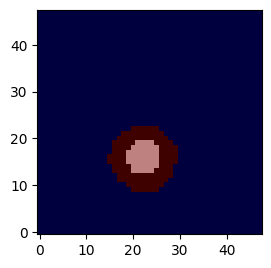

Jaccard Index for class 1: 0.7561
Percentage of matches in class 1: 100%


In [77]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_C, outputsB)

In [78]:
outputsB2 = []
for batch in test_dataloader_CE:
    data, *_ = batch
    output = lodestarB2((data)).detach()
    outputsB2.append(output)

outputsB2 = torch.cat(outputsB2, dim=0)

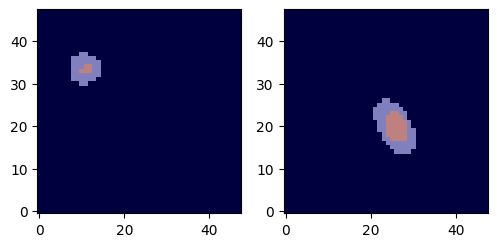

Jaccard Index for class 1: 0.8628
Percentage of matches in class 1: 92%
Jaccard Index for class 2: 0.8295
Percentage of matches in class 2: 98%


In [79]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_CE, outputsB2)

## Dropout method

For negative detection, check for a pixel and pixels right next to each other, in a way that we are able to identify individual chunks of 1, if those chunks don't overlap with the ground truth mask it's a false positive.

### Architecture and training

In [64]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)

import torch.nn.functional as F

class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        # num_outputs: int = 2,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        super().__init__(loss=None, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x

        # else:
        #     x, _, _ = x

        out = self.model(x)
        y = out[:, :3, ...]
        classes=out[:, 3:, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

        batch_size = classes.size(0)
        num_channels = classes.size(1)
        _, _, Hx, Wx = x.shape
        _, _, Hy, Wy = y.shape
        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy
        
        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(batch_size)

            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            
            mask = classes.sum(dim=1)[:,None]#torch.ones_like(y[:, 2:3, ...])


        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0:1, ...]
        delta_y = y[:, 1:2, ...]
        yy = y[:, 2:3, ...]
        weights = y[:, 2:3, ...].sigmoid()
        X = X + delta_x
        Y = Y + delta_y
        
        return torch.cat(
            [X, Y, weights, mask, classes], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights, mask_gumbel, classes = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:4], y_hat[:, 4:]

        dropout = nn.Dropout2d(p=0.1)
        mask_gumbel = dropout(mask_gumbel)
        
        weights =  mask_gumbel
        weights = self.normalize(weights)
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights 
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )
        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
        compl_mask=classes[:,:-1,...].sum(dim=1)[:,None]-mask_gumbel
        mask_loss = 10*compl_mask.mean(dim=(2, 3)).mean()

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
            "mask_loss": mask_loss,
        }

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y = self(x.to(self.device))
        y_pred, mask_gumbel = y[:, :2], y[:, 3:4]
        detections = [
            self.detect_single(y_pred[i], mask_gumbel[i], alpha, beta, cutoff, mode)
            for i in range(len(y_pred))
        ]
        
        detections = [row[::-1] for row in detections]
        return detections

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y = self(x.to(self.device))
        y_pred, weights,  = y[:, :2], y[:, 2:3]
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode)

    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile"):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]
        return np.array(detections)

    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)

    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        batch,_,_ = batch
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

In [65]:
import deeplay as dl

lodestarD = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
trainer_lodestarD = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestarD.fit(lodestarD, train_dataloader_C)


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

In [66]:
import deeplay as dl

lodestarD2 = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
trainer_lodestarD2 = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestarD2.fit(lodestarD2, train_dataloader_CE)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

### Segmentation tests
Calculate the jaccard index and percentage of successful detected objects by class

In [67]:
outputsD = []
for batch in test_dataloader_C:
    data, *_ = batch
    output = lodestarD((data)).detach()
    outputsD.append(output)

outputsD = torch.cat(outputsD, dim=0)

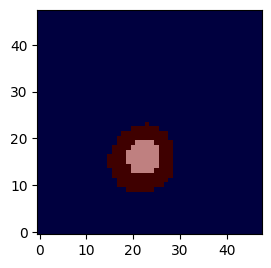

Jaccard Index for class 1: 0.7508
Percentage of matches in class 1: 100%


In [68]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_C, outputsD)

In [69]:
outputsD2 = []
for batch in test_dataloader_CE:
    data, *_ = batch
    output = lodestarD2((data)).detach()
    outputsD2.append(output)

outputsD2 = torch.cat(outputsD2, dim=0)

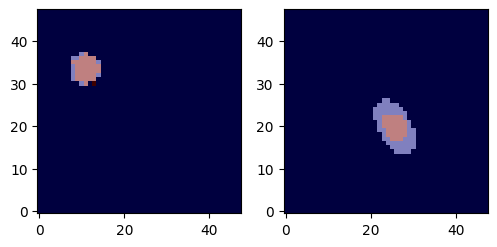

Jaccard Index for class 1: 0.9268
Percentage of matches in class 1: 91%
Jaccard Index for class 2: 0.8202
Percentage of matches in class 2: 99%


In [70]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_CE, outputsD2)

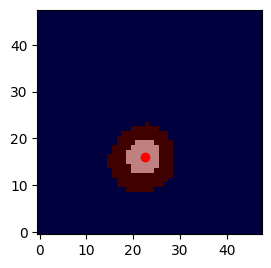

Class 1:
Jaccard Index: 0.7508
Recall %: 100%
Average number of artifacts: 0.48


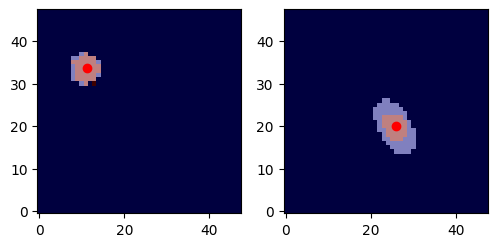

Class 1:
Jaccard Index: 0.9268
Recall %: 85%
Average number of artifacts: 1.09
Class 2:
Jaccard Index: 0.8202
Recall %: 98%
Average number of artifacts: 0.01


In [150]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import ndimage

def segmentation_tests(test_dataset, model_output):
    def jaccard_index(target, pred, smooth=1e-10):
        intersection = (pred.int() & target.int()).sum((1))
        union = (pred.int() | target.int()).sum((1))
        iou = (intersection + smooth) / (union + smooth)
        return iou.mean()

    # def recall(target, pred): # This one check for ground truth and mask overlaping, the new one uses positions which is more accurate and we need it for multiple object detection
    #     intersection = (target == 1) & (pred == 1)
    #     matches = (intersection.sum(dim=(1, 2)) > 0).sum().item()
    #     percentage_matches = (matches / target.size(0)) * 100
    #     return percentage_matches

    def recall_and_false_positives(mask, position):
        true_positives = 0
        artifacts = 0
    
        for i, single_mask in enumerate(mask):
            x, y = position[i]

            # Check for true positive
            if single_mask[int(x), int(y)] == 1:
                true_positives += 1
        
            # Count false positives
            labeled_array, num_regions = ndimage.label(single_mask)
            artifacts += num_regions
    
        recall = (true_positives / len(mask)) * 100
        false_positives = (artifacts - true_positives)/len(mask)
    
        return recall, false_positives
    
    # Get n_classes
    n_classes = model_output.size(1)-5

    # Get prediction mask
    mask = model_output[:, 4:n_classes+4]

    # Get original images
    sim =[]
    for i in range(n_classes):
        s = [item[i+1] for item in test_dataset] # By using item[0] we could get the ground truth directly from any image
        sim.append(torch.stack(s))
    sim = torch.stack(sim, dim=1)
    sim = torch.squeeze(sim, dim=2)

    # Get the positions
    positions = [item[-n_classes:] for item in test_dataset]
    positions = [torch.stack(item) for item in positions]
    positions = torch.stack(positions)
    positions = positions / 2

    # Downsize the image to 48x48
    reduced_images = F.interpolate(sim, size=(48, 48), mode='bilinear', align_corners=False)

    # Binarize tensors
    reduced_images = (reduced_images[:] > 0.1).float()

    # Plot the overlapping images
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.subplot(2, 4, i + 1)
        plt.imshow(reduced_images[0,i].squeeze(), cmap="gray", origin="lower")
        plt.imshow(mask[0,i].squeeze(), cmap="jet", alpha=0.5, origin="lower")
        plt.scatter(positions[0][i][1], positions[0][i][0], c="r")
    plt.tight_layout()
    plt.show()

    for i in range(n_classes):
        print(f"Class {i+1}:")
        recall_score, fp_count = recall_and_false_positives(mask[:,i], positions[:,i])
        print(f"Jaccard Index: {jaccard_index(reduced_images[:, i], mask[:, i]):.4f}")
        print(f"Recall %: {recall_score:.0f}%")
        print(f"Average number of artifacts: {fp_count}")

segmentation_tests(test_dataset_C, outputsD)
segmentation_tests(test_dataset_CE, outputsD2)

In [162]:
images, *_ = zip(*test_dataset_CE)
images = torch.stack(images)
results_CE = lodestarD2.detect(images)

In [164]:
def accuracy_tests(test_dataset, detect_results, n_class=1):
    # extract positions
    positions = list(zip(*test_dataset))[-n_class:] # Tis create a list with shape: positions[class][sample][x or y]
     # The model outputs the coordinates with shape: predictions[sample][class][x or y]

    mse_list = []

    for class_ in range(n_class):
        for sample in range(len(detect_results)):
            x = positions[class_][sample]
            y = torch.from_numpy(detect_results[sample][class_])

            # Calculate Mean Squared Error (MSE) 
            mse = torch.mean((y - x) ** 2)
            mse_list.append(mse.item())
    return mse_list

accuracy_tests(test_dataset_CE, results_CE, 2)

IndexError: index 0 is out of bounds for axis 0 with size 0